In [ ]:
# Standard data manipulation/visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# Custom text cleaning tool
import text_cleaner as cln

# Word clound library tools
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

# Sentiment analysis libraries
from textblob import TextBlob
import flair

# Interactive dashboard library
import streamlit

In [ ]:
input_file = "../data/raw_data/comments.csv"
raw_comments = pd.read_csv(input_file, lineterminator='\n').fil

In [ ]:
data = raw_comments.drop(['videoId', 'commentId', 'author'], axis=1)

# Preprocessing

In [ ]:
cleaner = cln.TextCleaner()
cleaned_comments = cleaner.clean(data['text'].astype(str))

In [ ]:
cleaned_data = data.copy()
cleaned_data['cleaned_comments'] = cleaned_comments

In [ ]:
cleaned_data.to_json('../data/cleaned_comments.csv')

# Sentiment Analysis

In [ ]:
sentiment_analysis = cleaned_data.copy()

## TextBlob pre-trained model

In [ ]:
textblob_results = {"positive":0,"neutral":0,"negative":0}
sentiment_polarity = []
sentiment_subj = []
for x in cleaned_data['cleaned_comments']: 
    res = TextBlob(x).sentiment
    sentiment_polarity.append(res[0])
    sentiment_subj.append(res[1])
    if res[0] == 0.0: 
        textblob_results["neutral"] +=1
    elif res[0] > 0.0:
        textblob_results["positive"] +=1
    else:
        textblob_results["negative"] +=1
print(textblob_results)

In [ ]:
labels = textblob_results.keys()
percentages = textblob_results.values()
explode = (0.1, 0, 0)

fig, ax = plt.subplots()
ax.pie(percentages, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')

plt.show()

In [ ]:
sentiment_analysis['textblob_polarity'] = sentiment_polarity
sentiment_analysis['textblob_subjectivity'] = sentiment_subj

## Flair pre-built model

In [ ]:
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

In [ ]:
flair_results = {"positive":0, "negative":0}
sentiment_val = []
sentiment_score = []
for x in cleaned_data['cleaned_comments']: 
    sentiment = flair.data.Sentence(x)
    flair_sentiment.predict(sentiment)
    res = sentiment.labels
    res = str(res[0]).replace('(', '').replace(')', '').split(' ')
    sentiment_val.append(res[0])
    sentiment_score.append(res[1])
    if res[0] == "POSITIVE":
        flair_results["positive"] +=1
    else:
        flair_results["negative"] +=1
print(flair_results)

In [ ]:
labels = flair_results.keys()
percentages = flair_results.values()
explode = (0.1, 0)

fig, ax = plt.subplots()
ax.pie(percentages, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')

plt.show()

In [ ]:
sentiment_analysis['flair_sentiment'] = sentiment_val
sentiment_analysis['flair_score'] = sentiment_score

In [ ]:
sentiment_analysis.to_json('../data/sentiment_analysis.csv')

In [ ]:
model_results = pd.DataFrame()
model_results = model_results.append(pd.DataFrame(data=[textblob_results.values()], columns=['positive', 'neutral', 'negative'], index=['textblob']))
model_results = model_results.append(pd.DataFrame(data=[flair_results.values()], columns=['positive', 'negative'], index=['flair']))
model_results = model_results.T
model_results.to_csv('../data/model_results.csv')

# Word Blob

In [3]:
df = pd.read_json("../data/sentiment_analysis.csv")

In [9]:
df.head()

,text,likeCount,publishedAt,cleaned_comments,textblob_polarity,textblob_subjectivity,flair_sentiment,flair_score,comment_length
0,This game are mix with the 80s and the future....,0,2020-05-25T10:59:01Z,"[game, mix, future, uwu, thats, neat]",-0.200000,0.2625,POSITIVE,0.9821,65
1,"29:02 ""Remember, these guys are really *shit* """,0,2020-05-25T10:56:37Z,"[remember, guy, really, shit]",-0.200000,0.8000,NEGATIVE,0.9993,47
2,I would replay this game 100x 💯‼,1,2020-05-25T10:19:23Z,"[would, replay, game, x]",-0.400000,0.4000,NEGATIVE,0.7817,32
3,So you could complete the game without killing...,1,2020-05-25T10:18:57Z,"[could, complete, game, without, killing, anyone]",-0.150000,0.4000,NEGATIVE,0.9934,55
4,"After listening to this video, I'm wondering i...",0,2020-05-25T09:54:34Z,"[listening, video, im, wondering, mod, music, ...",0.033333,0.6000,NEGATIVE,0.9955,209


In [5]:
mask = np.array(Image.open('../images/reeves.png'))

In [6]:
words = ''
for x in df['cleaned_comments']:
    words += "".join(str(x).strip("[]").replace("'", "").replace(",", ""))

In [7]:
wordcloud = WordCloud(background_color="white", max_words=10000, random_state=42, mask=mask).generate(words)

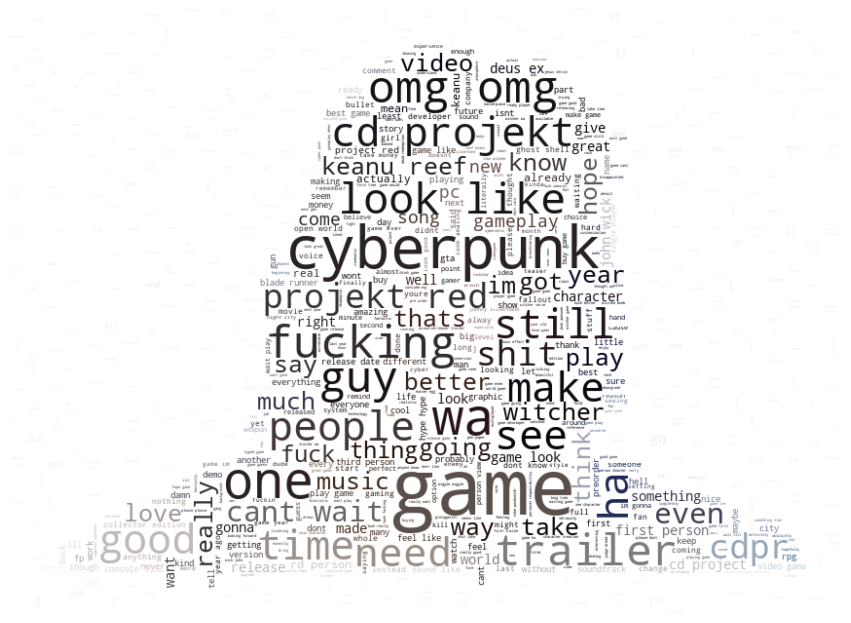

In [8]:
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[15,15])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis("off")
plt.show()

# Creating SQLite Database File

In [ ]:
# model_results.to_csv('../data/model_results.csv')

In [ ]:
# df.to_json('../data/sentiment_analysis.csv')

In [ ]:
# df.to_csv('../data/csv_results.csv', index=False)
# options = csv_to_sqlite.CsvOptions(typing_style="full", encoding="utf-8") 
# csv_to_sqlite.write_csv(['../data/csv_results.csv'], "sentiment_analysis_db.sqlite", options)